In [116]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense,Embedding,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import cufflinks as cf
import tensorflow
from tensorflow.keras import Sequential
from plotly.offline import iplot
py.offline.init_notebook_mode(connected=True)
cf.go_offline()
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
import warnings
warnings.filterwarnings("ignore")

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
df=pd.read_excel('/content/drive/MyDrive/Ecommerce Sentiment Analysis/Dataset/English Dataset.xlsx')

In [120]:
df.columns=["Comments","sentiment"]

In [121]:
df.head()

,Comments,sentiment
0,This product is not good.,Negative
1,100% Authentic Product,Positive
2,There is a 5 year warranty!,Positive
3,Excellent service from Picabo.,Positive
4,There is no doubt about the pierit.,Positive


In [122]:
df.dropna(inplace=True)

In [123]:
df.shape

(2577, 2)

In [124]:
print("Total Comment:",len(df),
      "\nTotal Negative :",len(df[df.sentiment =='Negative']),
      "\nTotal Positive :",len(df[df.sentiment=='Positive']))

Total Comment: 2577 
Total Negative : 1138 
Total Positive : 1439


In [125]:
import os

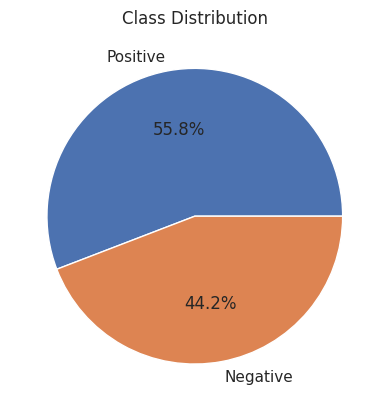

In [126]:
class_counts = df['sentiment'].value_counts()
class_percents = class_counts / class_counts.sum() * 100
# Plot the pie chart
plt.pie(class_percents, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.savefig("my_plot.png")
plt.show()

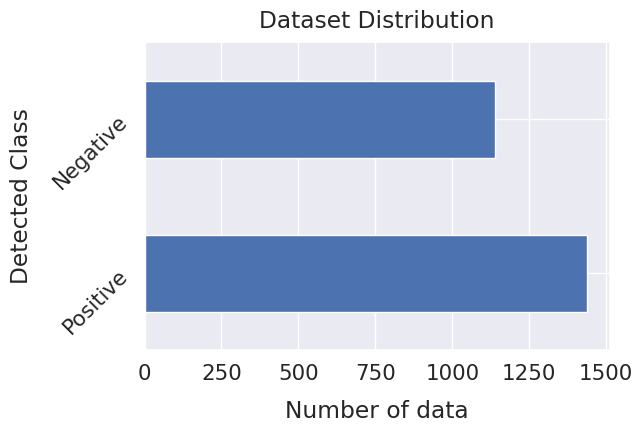

In [127]:
sns.set(font_scale=1.4)
df['sentiment'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of data", labelpad=12)
plt.ylabel("Detected Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);
plt.savefig("Dataset Distribution BarChart.png")

# **Data Preperation and Cleaning**

In [128]:
df["Lower_Case"] = df["Comments"].str.lower()
df.head()

,Comments,sentiment,Lower_Case
0,This product is not good.,Negative,this product is not good.
1,100% Authentic Product,Positive,100% authentic product
2,There is a 5 year warranty!,Positive,there is a 5 year warranty!
3,Excellent service from Picabo.,Positive,excellent service from picabo.
4,There is no doubt about the pierit.,Positive,there is no doubt about the pierit.


In [129]:
df.shape

(2577, 3)

# **Removing Duplicate Rows**

In [130]:
# df.drop_duplicates(inplace=True)

In [131]:
df.shape

(2577, 3)

# **Stopwords Removal**

In [132]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [133]:
import string
from nltk.corpus import stopwords

def process_text(text):
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    return ' '.join([word for word in no_punc.split() if word.lower() not in stopwords.words('english')])

In [134]:
df.dtypes

Comments      object
sentiment     object
Lower_Case    object
dtype: object

In [135]:
df["Lower_Case"]=df["Lower_Case"].astype(str)

In [136]:
df['Stopwords']=df['Lower_Case'].apply(process_text)

In [137]:
df.head()

,Comments,sentiment,Lower_Case,Stopwords
0,This product is not good.,Negative,this product is not good.,product good
1,100% Authentic Product,Positive,100% authentic product,100 authentic product
2,There is a 5 year warranty!,Positive,there is a 5 year warranty!,5 year warranty
3,Excellent service from Picabo.,Positive,excellent service from picabo.,excellent service picabo
4,There is no doubt about the pierit.,Positive,there is no doubt about the pierit.,doubt pierit


# **Removing Small Texts**

In [138]:
df['length'] = df['Stopwords'].apply(lambda x:len(x.split()))

dataset = df.loc[df.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small conversations".format(len(df)-len(dataset)),
      "\nTotal conversations:",len(dataset))

dataset['no_char'] = df['Stopwords'].apply(lambda cleaned: len(cleaned))

After Cleaning: 
Removed 0 Small conversations 
Total conversations: 2577


In [139]:
dataset.shape

(2577, 6)

# **Stemming**

In [140]:
import nltk
from nltk.stem import LancasterStemmer

nltk.download('lancaster')

[nltk_data] Error loading lancaster: Package 'lancaster' not found in
[nltk_data]     index


False

In [141]:
from nltk.stem import LancasterStemmer, PorterStemmer
import pandas as pd

# Instantiate stemmers
lancaster_stemmer = LancasterStemmer()
porter_stemmer = PorterStemmer()

# Define stemming functions
def lancaster_stemming(text):
    return ' '.join([lancaster_stemmer.stem(word) for word in text.split()])

def porter_stemming(text):
    return ' '.join([porter_stemmer.stem(word) for word in text.split()])

# Apply stemming to the dataset
dataset['LancasterStemming'] = dataset['Stopwords'].apply(lancaster_stemming)
dataset['PorterStemming'] = dataset['Stopwords'].apply(porter_stemming)

# Compare the performances
comparison_df = pd.DataFrame({
    'Original Text': dataset['Stopwords'],
    'Lancaster Stemming': dataset['LancasterStemming'],
    'Porter Stemming': dataset['PorterStemming']
})

In [142]:
comparison_df.head(20)

,Original Text,Lancaster Stemming,Porter Stemming
0,product good,produc good,product good
1,100 authentic product,100 auth produc,100 authent product
2,5 year warranty,5 year warranty,5 year warranti
3,excellent service picabo,excel serv picabo,excel servic picabo
4,doubt pierit,doubt pierit,doubt pierit
5,holes many spots shirts,hol many spot shirt,hole mani spot shirt
6,havent received order yet,hav receiv ord yet,havent receiv order yet
7,outstanding beat great sound,outstand beat gre sound,outstand beat great sound
8,perfumes original,perfum origin,perfum origin
9,negative impact company,neg impact company,neg impact compani


In [143]:
dataset.head()

,Comments,sentiment,Lower_Case,Stopwords,length,no_char,LancasterStemming,PorterStemming
0,This product is not good.,Negative,this product is not good.,product good,2,12,produc good,product good
1,100% Authentic Product,Positive,100% authentic product,100 authentic product,3,21,100 auth produc,100 authent product
2,There is a 5 year warranty!,Positive,there is a 5 year warranty!,5 year warranty,3,15,5 year warranty,5 year warranti
3,Excellent service from Picabo.,Positive,excellent service from picabo.,excellent service picabo,3,24,excel serv picabo,excel servic picabo
4,There is no doubt about the pierit.,Positive,there is no doubt about the pierit.,doubt pierit,2,12,doubt pierit,doubt pierit


In [144]:
dataset.drop(["Comments","Lower_Case","Stopwords","PorterStemming"],axis=1,inplace=True)

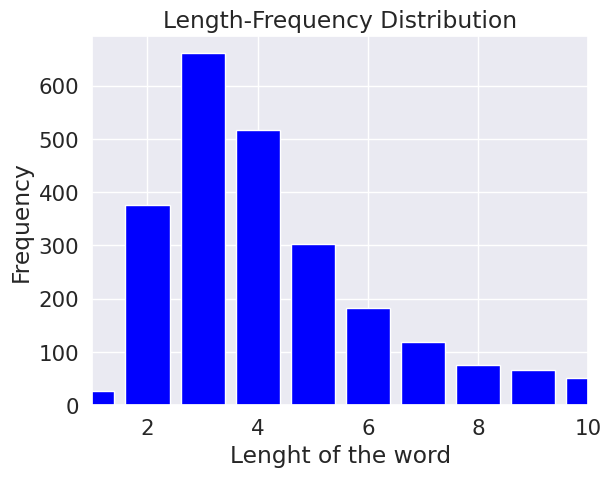

Maximum Length of a comment: 62
Minimum Length of a comment: 1
Average Length of a comment: 5.0


In [145]:
frequency = dict()
for i in dataset.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 10)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.length)}")
print(f"Minimum Length of a comment: {min(dataset.length)}")
print(f"Average Length of a comment: {round(np.mean(dataset.length),0)}")

In [146]:
dataset

,sentiment,length,no_char,LancasterStemming
0,Negative,2,12,produc good
1,Positive,3,21,100 auth produc
2,Positive,3,15,5 year warranty
3,Positive,3,24,excel serv picabo
4,Positive,2,12,doubt pierit
...,...,...,...,...
2572,Positive,14,92,headphon real awesom lot beauty sound sound lo...
2573,Negative,5,35,qual headphon good pric rang
2574,Positive,7,41,best heavy gam camer also much bet
2575,Positive,4,21,ye happy good stat


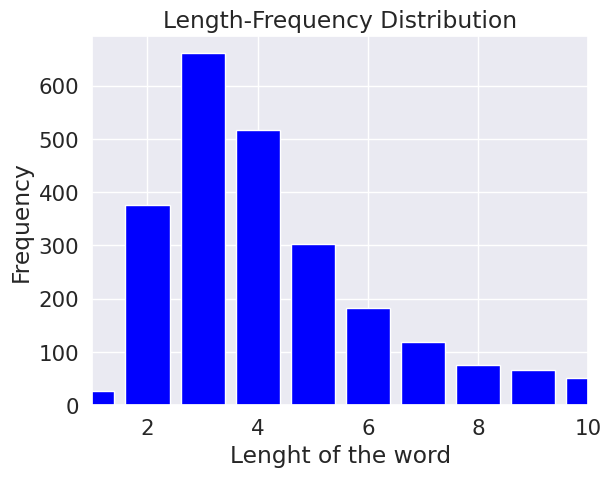

Maximum Length of a comment: 62
Minimum Length of a comment: 1
Average Length of a comment: 5.0


<Figure size 640x480 with 0 Axes>

In [147]:
frequency = dict()
for i in dataset.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 10)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.length)}")
print(f"Minimum Length of a comment: {min(dataset.length)}")
print(f"Average Length of a comment: {round(np.mean(dataset.length),0)}")

plt.savefig("Length-Frequency Distribution Bangla BarChart.png")

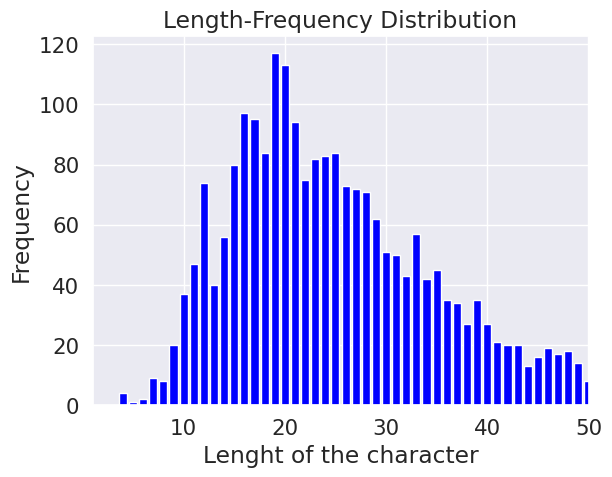

Maximum Length of a comment: 402
Minimum Length of a comment: 4
Average Length of a comment: 33.0


<Figure size 640x480 with 0 Axes>

In [148]:
frequency = dict()
for i in dataset.no_char:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 50)

plt.xlabel('Lenght of the character')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a comment: {max(dataset.no_char)}")
print(f"Minimum Length of a comment: {min(dataset.no_char)}")
print(f"Average Length of a comment: {round(np.mean(dataset.no_char),0)}")
plt.savefig("Character Frequency Distribution Bangla BarChart.png")

In [149]:
dataset.drop(["length","no_char"],axis=1,inplace=True)

In [150]:
dataset.head()

,sentiment,LancasterStemming
0,Negative,produc good
1,Positive,100 auth produc
2,Positive,5 year warranty
3,Positive,excel serv picabo
4,Positive,doubt pierit


In [151]:
dataset.columns=["sentiment","cleaned"]

# **Data Set Summary**

In [152]:
def data_summary(dataset):
    documents = []
    words = []
    most_frequent_word =[]
    u_words = []

    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.sentiment.value_counts().to_dict().items()]

    for label in class_label:
        word_list = [word.strip().lower() for t in list(dataset[dataset.sentiment==label].cleaned) for word in t.strip().split()]

        counts = dict()

        for word in word_list:
                counts[word] = counts.get(word, 0)+1

        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)

        documents.append(len(list(dataset[dataset.sentiment==label].cleaned)))

        words.append(len(word_list))

        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ",label)
        print("Number of comments:{}".format(len(list(dataset[dataset.sentiment==label].cleaned))))
        print("Number of Words:{}".format(len(word_list)))
        print("Number of Unique Words:{}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k,v in ordered[:15]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))

    return documents,words,u_words,class_label

documents,words,u_words,class_names = data_summary(dataset)


Class Name :  Positive
Number of comments:1439
Number of Words:7557
Number of Unique Words:1083
Most Frequent Words:

good	510
produc	409
pric	260
qual	199
thank	182
got	133
sel	118
want	99
bet	95
tak	88
giv	88
beauty	86
much	82
lik	82
alhamdulillah	82

Class Name :  Negative
Number of comments:1138
Number of Words:5465
Number of Unique Words:1126
Most Frequent Words:

produc	276
qual	184
bad	146
good	145
giv	98
buy	75
on	74
daras	70
ord	63
pric	56
wast	54
low	54
col	52
money	51
pict	48
Total Number of Unique Words:1641


***New Dataframe for Data Summary***

In [153]:
data_matrix = pd.DataFrame({'Total comments':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")

In [154]:
data

,Class Names,Category,Values
0,Positive,Total comments,1439
1,Negative,Total comments,1138
2,Positive,Total Words,7557
3,Negative,Total Words,5465
4,Positive,Unique Words,1083
5,Negative,Unique Words,1126


***Data Summary Visualization***

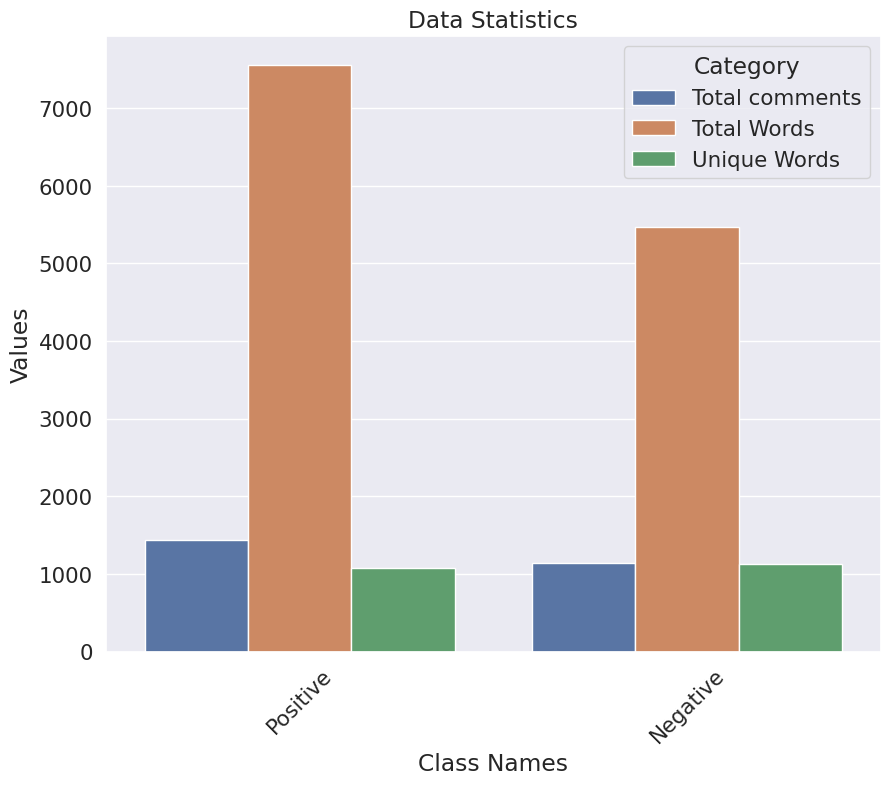

In [155]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.barplot(data=data,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

plt.savefig("Data Statistics Bangla BarChart.png")

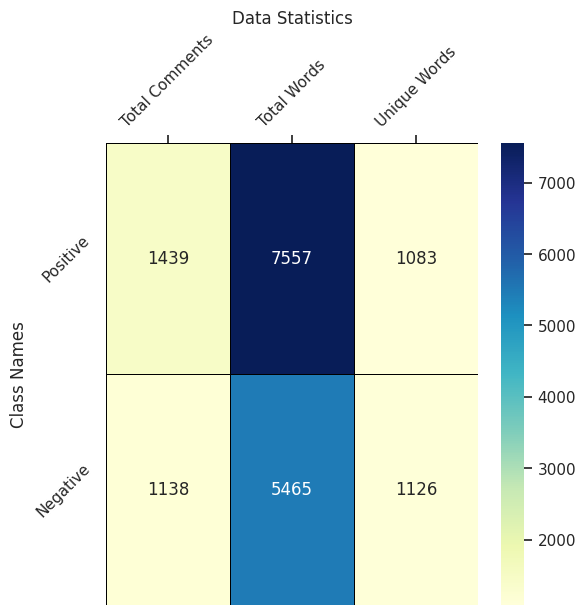

In [156]:
sns.set()
plt.figure(figsize =(6, 6))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)

ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Comments", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()
plt.savefig("Data Statistics Bangla.png")

In [157]:
dataset.cleaned = dataset.cleaned.apply(lambda x:x.replace('\n',' '))

In [158]:
dataset.head()

,sentiment,cleaned
0,Negative,produc good
1,Positive,100 auth produc
2,Positive,5 year warranty
3,Positive,excel serv picabo
4,Positive,doubt pierit


In [159]:
# dataset=dataset.drop(["Comments","cleaned","length","no_char"],axis=1)

# ***Unigram Tf-idf value calculation***

In [160]:
def calc_gram_tfidf(Conversations):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(Conversations)

    return tfidf,X

# **Unigram**

In [161]:
x = ["I got from you inactive products that are very unexpected"]

def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

get_top_n_words(x,3)

[('got', 1), ('from', 1), ('you', 1)]

# **Bigram**

In [162]:
y = ["I got from you inactive products that are very unexpected"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(y,3)

[('got from', 1), ('from you', 1), ('you inactive', 1)]

# **Tigram**

In [163]:
z = ["I got from you inactive products that are very unexpected"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(z,3)

[('got from you', 1), ('from you inactive', 1), ('you inactive products', 1)]

In [164]:
import warnings
warnings.filterwarnings("ignore")

In [165]:
# gram_names = ['Unigram','Bigram','Trigram']
# ngrams = [(1,1),(1,2),(1,3)]

# for i,gram in enumerate(ngrams):
#      tfidf,feature = calc_gram_tfidf(dataset.stemming)
#      labels = label_encoding(dataset.sentiment,False)
#      X_train,X_test,y_train,y_test = dataset_split(feature,labels)
#      ml_models,model_names = ml_models_defination()
#      accuracy = {f'{model_names[j]}': model_performance(model, X_train, X_test, y_train, y_test) for j, model in enumerate(ml_models)}

#      with open(f'ml_performance_{gram_names[i]}.json', 'w') as f:
#            json.dump(accuracy,f)

# **Tokenization**

In [166]:
max_fatures = 500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['cleaned'].values)
X = tokenizer.texts_to_sequences(dataset['cleaned'].values)
X = pad_sequences(X)

In [167]:
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ..., 403, 243,   1],
       [  0,   0,   0, ...,   0,   0,  55],
       ...,
       [  0,   0,   0, ...,  57,  18,  12],
       [  0,   0,   0, ...,  71,   2, 371],
       [  0,   0,   0, ...,   0,   7, 379]], dtype=int32)

In [168]:
np.shape(X)

(2577, 55)

# **Model Creation**

# **Combine**

In [169]:
X.shape

(2577, 55)

In [170]:
import keras
import tensorflow as tf

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense

max_features = max_fatures # Set the maximum number of features
embed_dim = 64
filters = 128
kernel_size = 5

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(256, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 55, 64)            32000     
                                                                 
 conv1d_2 (Conv1D)           (None, 51, 128)           41088     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 128)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                      

In [172]:
Y = pd.get_dummies(dataset['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2061, 55) (2061, 2)
(516, 55) (516, 2)


In [173]:
history=model.fit(X_train, Y_train, epochs = 50, batch_size=32, verbose = 1,validation_data=(X_test,Y_test))

Epoch 1/50
65/65 [==============================] - 9s 92ms/step - loss: 0.6912 - accuracy: 0.5502 - val_loss: 0.6882 - val_accuracy: 0.5601
Epoch 2/50
65/65 [==============================] - 6s 93ms/step - loss: 0.6872 - accuracy: 0.5580 - val_loss: 0.6856 - val_accuracy: 0.5601
Epoch 3/50
65/65 [==============================] - 5s 84ms/step - loss: 0.6710 - accuracy: 0.5580 - val_loss: 0.6497 - val_accuracy: 0.5601
Epoch 4/50
65/65 [==============================] - 6s 99ms/step - loss: 0.6239 - accuracy: 0.7322 - val_loss: 0.6180 - val_accuracy: 0.7481
Epoch 5/50
65/65 [==============================] - 5s 83ms/step - loss: 0.5812 - accuracy: 0.8074 - val_loss: 0.5984 - val_accuracy: 0.7422
Epoch 6/50
65/65 [==============================] - 4s 54ms/step - loss: 0.5493 - accuracy: 0.8205 - val_loss: 0.5856 - val_accuracy: 0.7442
Epoch 7/50
65/65 [==============================] - 4s 57ms/step - loss: 0.5202 - accuracy: 0.8379 - val_loss: 0.5708 - val_accuracy: 0.7500
Epoch 8/50
65

In [174]:
import tensorflow as tf

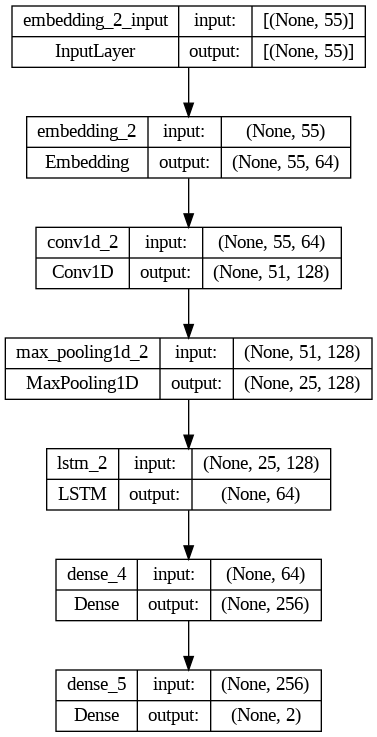

In [175]:
tf.keras.utils.plot_model(model, show_shapes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-hxkd_ntm
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-hxkd_ntm
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 16.3 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13719 sha256=60034b50df4ceb5aeb9f76cb53a9b8f8158eec295e4fde1bcee7f643c0d88787
  Stored in directory: /tmp/pip-ephem-wheel-cache-t300kiv1/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


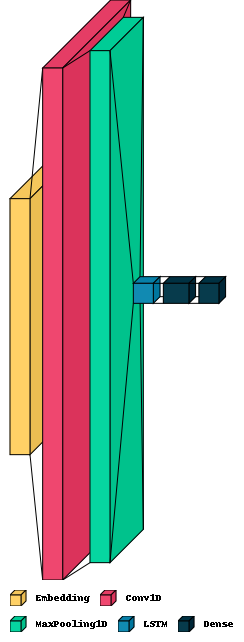

In [176]:
from tensorflow.keras.models import Model
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

# **Evaluation**

In [177]:
score = model.evaluate(X_train, Y_train,batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

33/33 - 0s - loss: 0.2991 - accuracy: 0.8933 - 351ms/epoch - 11ms/step
Train loss: 0.2990949749946594
Train accuracy: 0.8932557106018066


In [178]:
score = model.evaluate(X_test, Y_test,batch_size=64, verbose=2)
print('Test loss:', score[0])
acc=score[1]
print('Test accuracy:', acc)


9/9 - 0s - loss: 0.6229 - accuracy: 0.7364 - 104ms/epoch - 12ms/step
Test loss: 0.6228541731834412
Test accuracy: 0.7364341020584106


# **Learning Curve**

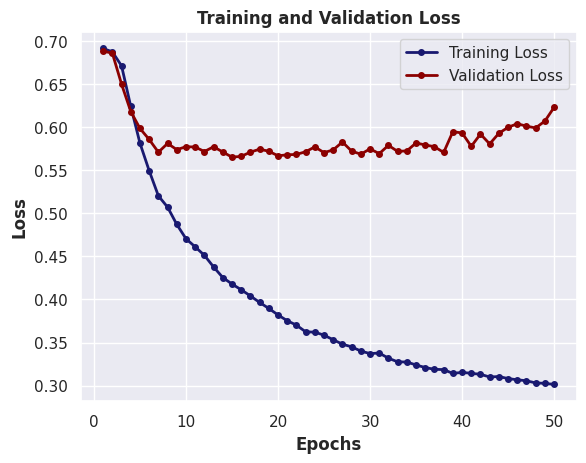

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, loss_values, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Loss')
plt.plot(epochs, val_loss_values, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

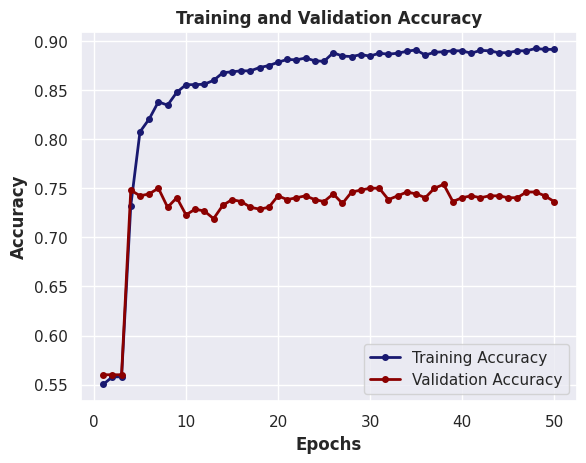

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, acc, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


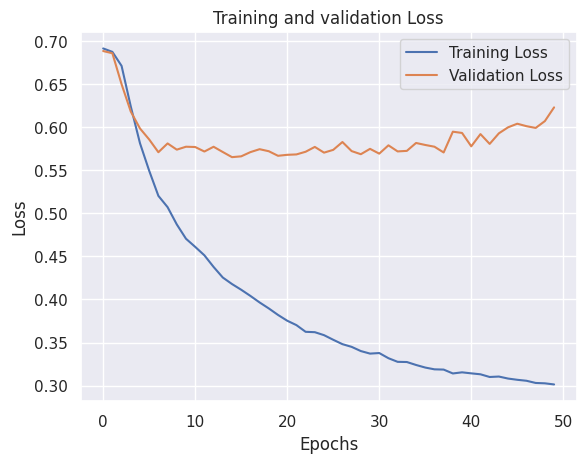

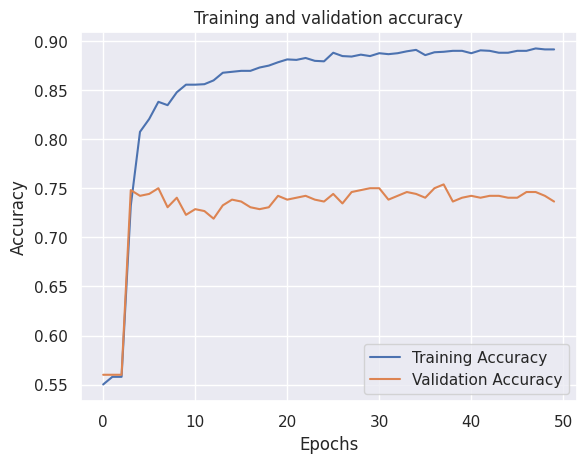

In [181]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

### **Confusion Matrix & Classification Report**

In [182]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((2061, 55), (2061, 2), (516, 55), (516, 2))

In [183]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

17/17 [==============================] - 0s 10ms/step
[[156  71]
 [ 65 224]]


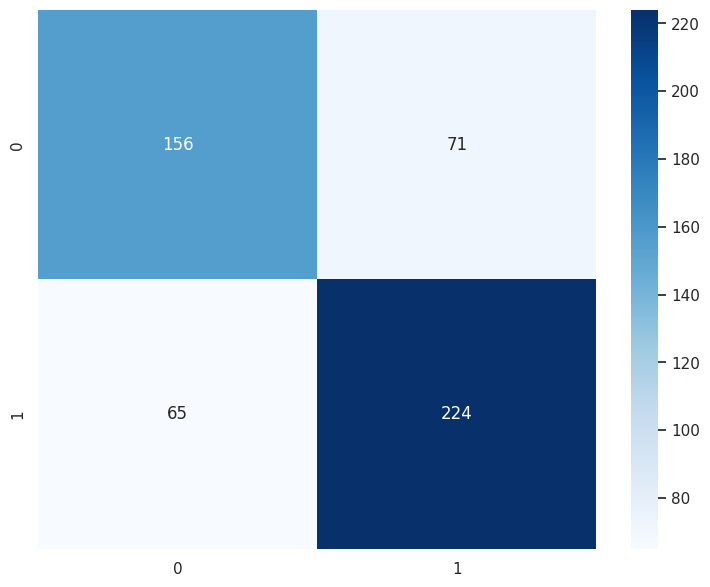

In [184]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm,cmap='Blues', annot=True,fmt='d')
plt.show()


In [185]:
# print(classification_report(y_test, y_pred))

In [186]:
from sklearn.metrics import classification_report

In [187]:
report = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).transpose()

In [188]:
report = report.rename(index={'0': 'Positive','1':'Negative'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))

In [189]:
report

,precision,recall,f1-score,support
Positive,70.59,68.72,69.64,227.000000
Negative,75.93,77.51,76.71,289.000000
accuracy,73.64,73.64,73.64,0.736434
macro avg,73.26,73.12,73.18,516.000000
weighted avg,73.58,73.64,73.60,516.000000


In [190]:
twt = ['Good product']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("Positive")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]
1/1 - 0s - 276ms/epoch - 276ms/step
Positive
